In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [13]:
# Step 1: Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Step 2: Calculate daily returns
returns = data['Close'].pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [14]:
# Print the columns of the downloaded data
print(returns)

Ticker          AAPL      AMZN      GOOG      MSFT      TSLA
Date                                                        
2020-01-03 -0.009722 -0.012139 -0.004907 -0.012452  0.029633
2020-01-06  0.007968  0.014886  0.024657  0.002585  0.019255
2020-01-07 -0.004703  0.002092 -0.000624 -0.009118  0.038801
2020-01-08  0.016086 -0.007809  0.007880  0.015928  0.049205
2020-01-09  0.021241  0.004799  0.011044  0.012493 -0.021945
...              ...       ...       ...       ...       ...
2022-12-23 -0.002798  0.017425  0.017562  0.002267 -0.017551
2022-12-27 -0.013878 -0.025924 -0.020933 -0.007414 -0.114089
2022-12-28 -0.030685 -0.014692 -0.016718 -0.010255  0.033089
2022-12-29  0.028324  0.028844  0.028799  0.027630  0.080827
2022-12-30  0.002469 -0.002138 -0.002473 -0.004937  0.011164

[755 rows x 5 columns]


In [15]:
# Step 3: Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [16]:
# Step 4: Implementing the Mean-Variance Optimization
# Defining the optimization problem
n_assets = len(tickers)

# Convert mean returns and covariance matrix to cvxopt format
mean_returns = np.array(mean_returns)
cov_matrix = np.array(cov_matrix)

# Covert data to cvxopt matrices
P = matrix(cov_matrix)  # Covariance matrix
q = matrix(np.zeros(n_assets))  # No linear term (we're not adding any risk-free asset)

# Constraints: sum of weights = 1 (fully invested portfolio)
G = matrix(-np.eye(n_assets))  # Negative identity matrix for weight constraints (all weights >= 0)
h = matrix(np.zeros(n_assets))  # No short selling (weights >= 0)

A = matrix(np.ones((1, n_assets)))  # Sum of weights constraint
b = matrix(np.ones(1))  # The sum of weights must equal 1


In [17]:
print(P)

[ 5.41e-04  3.80e-04  3.67e-04  4.13e-04  5.50e-04]
[ 3.80e-04  6.06e-04  3.64e-04  3.78e-04  5.34e-04]
[ 3.67e-04  3.64e-04  4.69e-04  3.91e-04  4.46e-04]
[ 4.13e-04  3.78e-04  3.91e-04  4.79e-04  4.99e-04]
[ 5.50e-04  5.34e-04  4.46e-04  4.99e-04  2.07e-03]



In [18]:
# Solve the optimization problem
sol = solvers.qp(P, q, G, h, A, b)

# Extract portfolio weights
weights = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  2.5602e-04 -9.9985e-01  1e+00  1e-16  3e+00
 1:  2.5597e-04 -9.8486e-03  1e-02  1e-16  3e-02
 2:  2.5176e-04  5.5152e-05  2e-04  1e-16  5e-04
 3:  2.1899e-04  1.8885e-04  3e-05  6e-17  5e-05
 4:  2.0858e-04  2.0516e-04  3e-06  7e-17  9e-20
 5:  2.0672e-04  2.0653e-04  2e-07  2e-16  8e-20
 6:  2.0655e-04  2.0655e-04  2e-09  2e-16  1e-19
Optimal solution found.


Optimized Portfolio Weights:
{'AAPL': np.float64(0.19229233697311035), 'MSFT': np.float64(0.17651423026156673), 'TSLA': np.float64(0.40473498378900896), 'AMZN': np.float64(0.22643418679558328), 'GOOG': np.float64(2.4262180730523584e-05)}


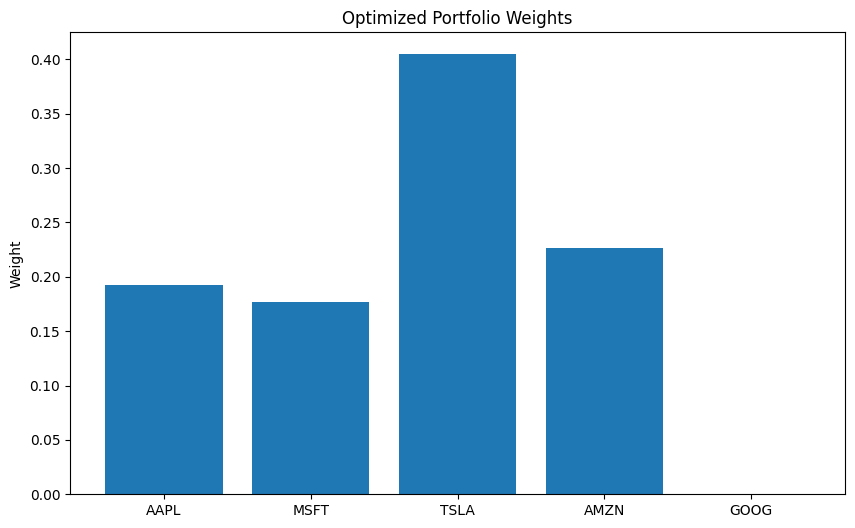

In [19]:
# Step 5: Display results
print(f"Optimized Portfolio Weights:\n{dict(zip(tickers, weights))}")

# Step 6: Plot the optimized portfolio
plt.figure(figsize=(10,6))
plt.bar(tickers, weights)
plt.title("Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.show()

In [20]:
# Step 7: Calculate Portfolio Return and Risk
portfolio_return = np.sum(weights * mean_returns) * 252  # Annualize the return (252 trading days)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualize the volatility

print(f"Expected Annual Portfolio Return: {portfolio_return:.2f}")
print(f"Expected Annual Portfolio Volatility: {portfolio_volatility:.2f}")

Expected Annual Portfolio Return: 0.16
Expected Annual Portfolio Volatility: 0.32
